# Numerical Solution of the Two-Dimensional Helmholtz Equation with Robin Boundary Conditions using the Finite Element Method

This notebook illustrates the numerical solution of the two-dimensional wave equation for an harmonic excitation and Robin boundary conditions using the [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method) (FEM).

## Problem Statement

The inhomogeneous [Helmholtz equation](https://en.wikipedia.org/wiki/Helmholtz_equation) is given as

\begin{equation}
\Delta P(\mathbf{x}, \omega) + \frac{\omega^2}{c^2} P(\mathbf{x}, \omega) = Q(\mathbf{x}, \omega)
\end{equation}

We aim for a numerical solution of the Helmholtz equation on the domain $V$ with respect to homogeneous Robin boundary conditions

\begin{equation}
\frac{\partial}{\partial n} P(\mathbf{x}, \omega) + j \sigma P(\mathbf{x}, \omega) = 0 \qquad \text{for } x \in \partial V 
\end{equation}

where $\partial V $ denotes the boundary of $V$.

* where does the imaginary unit come from in the Robin formulation?
* physical/acoustical interpretation of $\sigma$?

## Variational Formulation

Starting from the [variational formulation of the Helmholtz equation](FEM_Helmholtz_equation_2D.ipynb#Variational-Formulation) (before application of Green's first theorem)

\begin{equation}
- \int_V \nabla P(\mathbf{x}, \omega) \cdot \nabla V(\mathbf{x}, \omega) dx  + 
\int_{\partial V} V(\mathbf{x}, \omega) \frac{\partial}{\partial n}  P(\mathbf{x}, \omega) ds
+ \frac{\omega^2}{c^2} \int_V P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx = 
\int_V Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx
\end{equation}

Introducing the Robin boundary condition into the second integral (see https://math.stackexchange.com/questions/361423/variational-formulation-of-robin-boundary-value-problem-for-poisson-equation-in) yields

\begin{equation}
- \int_V \nabla P(\mathbf{x}, \omega) \cdot \nabla V(\mathbf{x}, \omega) dx  - 
j \sigma \int_{\partial V} V(\mathbf{x}, \omega) P(\mathbf{x}, \omega) ds
+ \frac{\omega^2}{c^2} \int_V P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx = 
\int_V Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx
\end{equation}


It is common to express this in terms of the bilinear $a(P, V)$ and linear $L(V)$ forms 

\begin{equation}
a(P, V) = \frac{\omega^2}{c^2} \int_V P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx 
- \int_V \nabla P(\mathbf{x}, \omega) \cdot \nabla V(\mathbf{x}, \omega) dx - 
j \sigma \int_{\partial V} V(\mathbf{x}, \omega) P(\mathbf{x}, \omega) ds
\end{equation}

\begin{equation}
L(V) = \int_V Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx
\end{equation}

where

\begin{equation}
a(P, V) = L(V)
\end{equation}

Practical implementations of the FEM (like FEniCS) may not be able to handle complex numbers. In this case the problem can be split into its real and imaginary part by introducing $P(\mathbf{x}, \omega) = P_r(\mathbf{x}, \omega) + j P_i(\mathbf{x}, \omega)$ and $V(\mathbf{x}, \omega) = V_r(\mathbf{x}, \omega) + j V_i(\mathbf{x}, \omega)$ and identifying the real and imaginary parts of the bilinear and linear forms. For the former we get

\begin{equation}
a_r = \int_V \left( \frac{\omega^2}{c^2} V_r(\mathbf{x}, \omega) P_r(\mathbf{x}, \omega) -  \frac{\omega^2}{c^2} V_i(\mathbf{x}, \omega) P_i(\mathbf{x}, \omega) - \nabla P_r(\mathbf{x}, \omega) \cdot \nabla V_r(\mathbf{x}, \omega) + \nabla P_i(\mathbf{x}, \omega) \cdot \nabla V_i(\mathbf{x}, \omega) \right) dx +
\sigma \int_{\partial V} \left( V_i(\mathbf{x}, \omega) P_r(\mathbf{x}, \omega) + V_r(\mathbf{x}, \omega) P_i(\mathbf{x}, \omega) \right) ds
\end{equation}

\begin{equation}
a_i = \int_V \left( \frac{\omega^2}{c^2} V_r(\mathbf{x}, \omega) P_i(\mathbf{x}, \omega) +  \frac{\omega^2}{c^2} V_i(\mathbf{x}, \omega) P_r(\mathbf{x}, \omega) - \nabla P_i(\mathbf{x}, \omega) \cdot \nabla V_r(\mathbf{x}, \omega) + \nabla P_r(\mathbf{x}, \omega) \cdot \nabla V_i(\mathbf{x}, \omega) \right) dx +
\sigma \int_{\partial V} \left( V_i(\mathbf{x}, \omega) P_i(\mathbf{x}, \omega) - V_r(\mathbf{x}, \omega) P_r(\mathbf{x}, \omega) \right) ds
\end{equation}

## Numerical Solution

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs. Its high-level Python interface `dolfin` is used in the following to define the problem and computing the solution. The implementation is based on the variational formulation derived above. It is common in the FEM to denote the solution of the problem by $u$ and the test function by $v$. The definition of the problem in FEniCS is very close to the mathematical formulation of the problem.

For the subsequent examples the solution of inhomogeneous wave equation for a point source $Q(\mathbf{x}) = \delta(\mathbf{x}-\mathbf{x_s})$ at position $\mathbf{x_s}$ is computed using the FEM. A function is defined for this purpose, as well as for the plotting of the resulting sound field.

In [1]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
%matplotlib inline


def Helmholtz_2D_Robin(mesh, frequency, xs, sigma=Constant(0), c=343):
    
    # squared wavenumber
    k2 = (Constant(2*pi*frequency)/Constant(c))**2
    
    # define function space
    V = VectorFunctionSpace(mesh, "CG", 1, dim=2)

    # define variational problem
    (u_r, u_i) = TrialFunction(V)
    (v_r, v_i) = TestFunction(V)

    a_r = ( k2 * inner(u_r,v_r) - k2 * inner(u_i,v_i) - inner(grad(u_r), grad(v_r)) + inner(grad(u_i), grad(v_i)) ) * dx  + sigma*inner(u_r, v_i) * ds + sigma*inner(u_i, v_r) * ds
    a_i = ( k2 * inner(u_r,v_i) + k2 * inner(u_i,v_r)  - inner(grad(u_r), grad(v_i)) - inner(grad(u_i), grad(v_r)) ) * dx  - sigma*inner(u_r, v_r) * ds + sigma*inner(u_i, v_i) * ds
    L_r = Constant(0.0) * v_r * dx
    L_i = Constant(0.0) * v_i * dx

    a = a_r + a_i
    L = L_r + L_i
    A, b = assemble_system(a, L)

    # define inhomogenity
    delta = PointSource(V.sub(0), xs, 1)
    delta.apply(b)

    # compute solution
    u = Function(V)
    solve(A, u.vector(), b)
    (u_r, u_i) = split(u)
    
    return u_r


def plot_soundfield(u):
    '''plots solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = plot(u)
    plt.title(r'$P(\mathbf{x}, \omega)$')
    plt.xlabel(r'$x$ in m')
    plt.ylabel(r'$y$ in m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);

### Sound Field in a Rectangular Room

The two-dimensional sound field in a rectangular room (rectangular plate) with Robin boundary conditions is computed for the frequency $f=1000$ Hz and source position $x_s = (1.2,3.2)$ m.

In [2]:
# define geometry and mesh
mesh = RectangleMesh(Point(0, 0), Point(5, 4), 200, 200, "right/left")

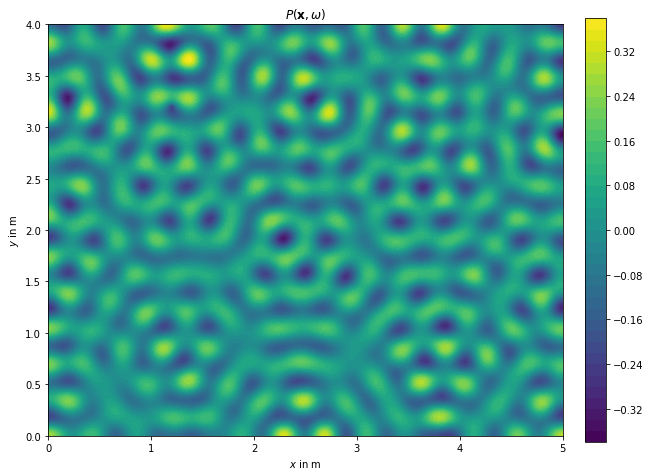

In [3]:
# compute solution for sigma=0 (Neumann boundary conditions)
u = Helmholtz_2D_Robin(mesh, 1000, Point(1.2, 3.2), sigma=Constant(0))

# plot sound field
plot_soundfield(u)

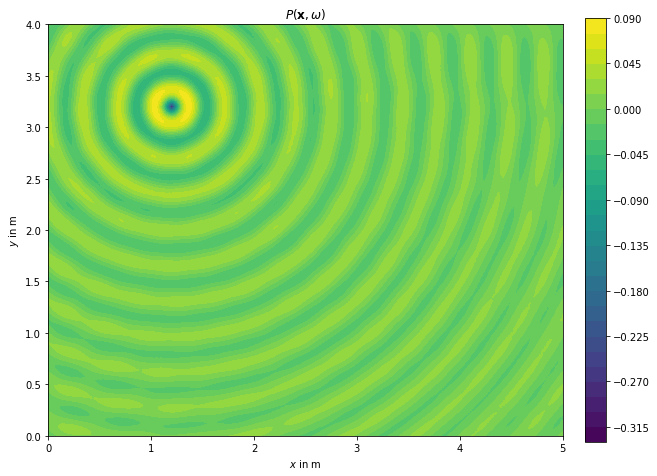

In [4]:
# compute solution for sigma = 15
u = Helmholtz_2D_Robin(mesh, 1000, Point(1.2, 3.2), sigma=Constant(15))

# plot sound field
plot_soundfield(u)

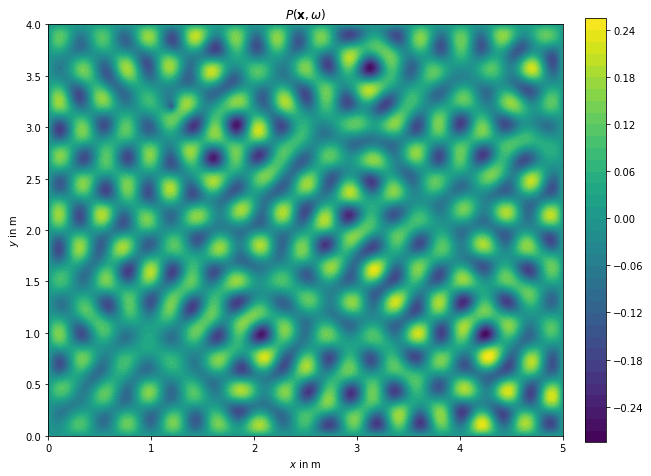

In [5]:
# compute solution for sigma = 1000
u = Helmholtz_2D_Robin(mesh, 1000, Point(1.2, 3.2), sigma=Constant(1000))

# plot sound field
plot_soundfield(u)

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).